In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
### Set up the pauli ops
I,X,Y,Z = np.matrix([[1,0],[0,1]]),np.matrix([[0,1],[1,0]]),np.matrix([[0,-1j],[1j,0]]),np.matrix([[1,0],[0,-1]])
[X0,Y0,Z0] = [np.kron(op,I) for op in [X,Y,Z]]
[X1,Y1,Z1] = [np.kron(I,op) for op in [X,Y,Z]]

In [3]:
from scipy.linalg import expm
def evolve(pulses, dt, H0, H_ops):
    """
    Compute the operator associated with a set of pulses
    
    (List[List[Float]]) pulses: The pulses. Each element should have length equal length
    (Float) dt: duration of each pulse
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    """
    U = np.identity(len(H0))
    for i in range(len(pulses[0])): 
        H = H0
        for k in range(len(pulses)):
            H = H + pulses[k][i] * H_ops[k]
        U=expm(-1j * dt * H) @ U
    return U
def getFidelity(dt, H0, H_ops,target):
    """
    Get an optimizable fidelity function for a set of pulses
    (Float) dt: Time increment
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    (np.matrix) target: The target state
    """
    def loss(coeffs):
        global iterations
        pulses = np.split(coeffs,len(H_ops))
        U=evolve(pulses, dt, H0, H_ops)
        fidelity = np.abs(np.trace(U.conjugate().transpose()@target))/len(target)
        return  -1 * fidelity 
    return loss 

In [4]:
import scipy
###Control and drift
H_ops = [Z0,X0,Y1,Z0@X1]
H0 = Z0+Z1
CNOT = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]

T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=CNOT)
                    ,x0=u0, bounds = [[-10,10]]*N*len(H_ops)
                 )
print("CNOT Fidelity: "+str(-1 * result.fun))

CNOT Fidelity: 0.9999999966731907


In [5]:
###The parameterized lookup table we want
def excitation(theta):
    return expm(1j * theta/2 * (X0@ Y1 - Y0 @ X1))

In [6]:
T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

coefficients = []
fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
    u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))
                        ,x0=u0
                     )
    coefficients.append(result.x)
    fidelities.append(-1*result.fun)
    print("Angle "+str(theta)+" completed with fidelity "+str(-1 * result.fun))

Angle 0.0 completed with fidelity 0.9999999137815146
Angle 0.3306939635357677 completed with fidelity 0.9999999998108364
Angle 0.6613879270715354 completed with fidelity 0.9999999997565149
Angle 0.992081890607303 completed with fidelity 0.9999999881799988
Angle 1.3227758541430708 completed with fidelity 0.9999999999313396
Angle 1.6534698176788385 completed with fidelity 0.999999999804715
Angle 1.984163781214606 completed with fidelity 0.9999999997344281
Angle 2.3148577447503738 completed with fidelity 0.9999999992824206
Angle 2.6455517082861415 completed with fidelity 0.9999999986957813
Angle 2.9762456718219092 completed with fidelity 0.9999999999544353
Angle 3.306939635357677 completed with fidelity 0.9999999847538307
Angle 3.6376335988934447 completed with fidelity 0.9999999995924174
Angle 3.968327562429212 completed with fidelity 0.999999999723582
Angle 4.29902152596498 completed with fidelity 0.9999999997391308
Angle 4.6297154895007475 completed with fidelity 0.9999999991430641
Ang

In [7]:
coefficients = np.array(coefficients)
def interpolate(theta,coefficients):
    coeffs = np.zeros(N*len(H_ops))
    for i in range(N*len(H_ops)):
        coeffs[i]=np.interp(x=theta,xp= np.linspace(0,2*np.pi,20),fp=coefficients.T[i])
    return coeffs

In [8]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,coefficients)))

Text(0, 0.5, 'fidelity')

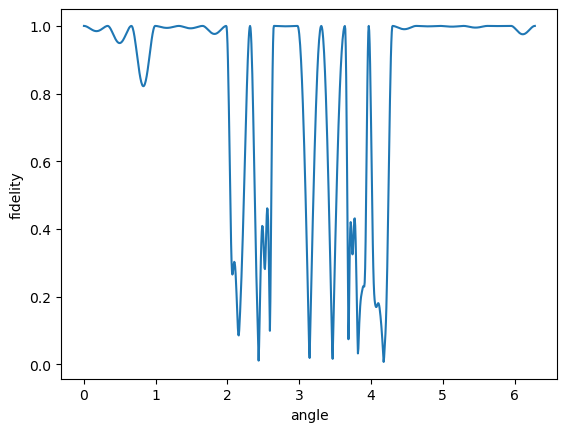

In [9]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [10]:
mean_coeffs = np.mean(coefficients,axis=0)

def getLossFidelity(dt, H0, H_ops,target,mean):
    """
    Get an optimizable fidelity function for a set of pulses
    (Float) dt: Time increment
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    (np.matrix) target: The target state
    """
    def loss(coeffs):
        global iterations
        pulses = np.split(coeffs,len(H_ops))
        U=evolve(pulses, dt, H0, H_ops)
        fidelity = np.abs(np.trace(U.conjugate().transpose()@target))/len(target)
        return  1 - 1 * fidelity + 0.1 * np.linalg.norm(coeffs - mean)
    return loss 

In [11]:
new_coefficients = []
new_fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
    u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    result = scipy.optimize.minimize(fun = getLossFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta),mean=mean_coeffs)
                        ,x0=u0
                     )
    new_coefficients.append(result.x)
    new_fidelities.append(-1*result.fun)
    print("------------")
    print("Angle "+str(theta))
    print("Loss "+str(result.fun))
    f=-1 * getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))(result.x)
    print("Fidelity "+str(f))


------------
Angle 0.0
Loss 0.08829558713169611
Fidelity 0.9906299225415992
------------
Angle 0.3306939635357677
Loss 0.1028537916273517
Fidelity 0.9849048035889152
------------
Angle 0.6613879270715354
Loss 0.12859010668187704
Fidelity 0.9846741913188771
------------
Angle 0.992081890607303
Loss 0.14777953684082085
Fidelity 0.9870457624287677
------------
Angle 1.3227758541430708
Loss 0.15491230750172258
Fidelity 0.9898382226226113
------------
Angle 1.6534698176788385
Loss 0.1553940297817625
Fidelity 0.9913229751852608
------------
Angle 1.984163781214606
Loss 0.1496341000167942
Fidelity 0.9920549507632185
------------
Angle 2.3148577447503738
Loss 0.2907778900147013
Fidelity 0.9960377499250259
------------
Angle 2.6455517082861415
Loss 0.1985043882805802
Fidelity 0.995257291453139
------------
Angle 2.9762456718219092
Loss 0.19450545635544625
Fidelity 0.996324541477236
------------
Angle 3.306939635357677
Loss 0.19486789803263183
Fidelity 0.9963957271783503
------------
Angle 3.637

In [12]:
new_coefficients = np.array(new_coefficients)

In [13]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,new_coefficients)))

Text(0, 0.5, 'fidelity')

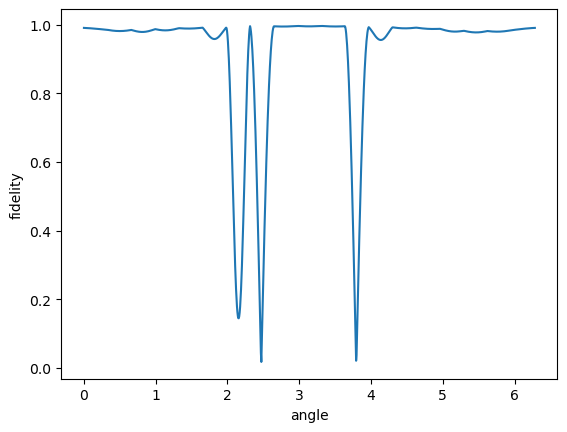

In [14]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [15]:
mean_coeffs = np.mean(new_coefficients,axis=0)
newer_coefficients = []
newer_fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
    u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    result = scipy.optimize.minimize(fun = getLossFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta),mean=mean_coeffs)
                        ,x0=u0
                     )
    newer_coefficients.append(result.x)
    newer_fidelities.append(-1*result.fun)
    print("------------")
    print("Angle "+str(theta))
    print("Loss "+str(result.fun))
    f=-1 * getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))(result.x)
    print("Fidelity "+str(f))


------------
Angle 0.0
Loss 0.08304265257088082
Fidelity 0.9896496229342971
------------
Angle 0.3306939635357677
Loss 0.0966035399779222
Fidelity 0.9869288948101413
------------
Angle 0.6613879270715354
Loss 0.11973418144963653
Fidelity 0.9869770899364119
------------
Angle 0.992081890607303
Loss 0.14137324581962832
Fidelity 0.9887630540948463
------------
Angle 1.3227758541430708
Loss 0.15418541207156752
Fidelity 0.9898072368725308
------------
Angle 1.6534698176788385
Loss 0.15682829510637314
Fidelity 0.9912021885561781
------------
Angle 1.984163781214606
Loss 0.14990353249624588
Fidelity 0.9930427188012799
------------
Angle 2.3148577447503738
Loss 0.1421103991476262
Fidelity 0.9937727459609276
------------
Angle 2.6455517082861415
Loss 0.16351967613835527
Fidelity 0.9947820516557319
------------
Angle 2.9762456718219092
Loss 0.16027322540763797
Fidelity 0.9958170320750762
------------
Angle 3.306939635357677
Loss 0.16079715307330106
Fidelity 0.9960433172690664
------------
Angle 

In [16]:
newer_coefficients = np.array(newer_coefficients)
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,newer_coefficients)))

Text(0, 0.5, 'fidelity')

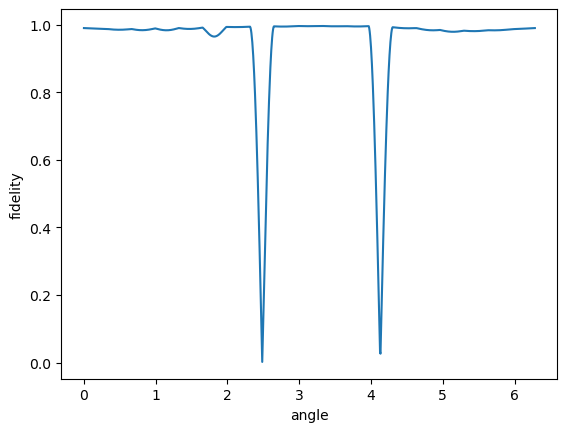

In [17]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")